## Лабораторная работа по курсу "Искусственный интеллект"
## Многослойный персептрон

| Студент | Ермакова |
|---------|----------|
| Группа  | 301      |

Для начала, скачаем датасет MNIST.

In [2]:
import torch
torch.__version__

'1.10.0+cu111'

In [3]:
import matplotlib.pyplot as plt

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print('Doing computations on '+device)


Doing computations on cpu


In [5]:
import torch
from torchvision import datasets, transforms

In [6]:
import torch.nn as nn
import torch.nn.functional as F

In [7]:
import torch.optim as optim

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [9]:
import seaborn as sns

In [81]:
b_size = 200

train = datasets.MNIST("", download=True, train=True, 
                          transform = transforms.Compose([
                                                          transforms.ToTensor()
                                                         ])
                          )
trainset = torch.utils.data.DataLoader(train, batch_size=b_size, shuffle=True)

In [80]:
b_size_test = 5000
test = datasets.MNIST("", download=True, train=False, 
                          transform = transforms.Compose([
                                                          transforms.ToTensor()                                                        
                                                         ])
                          )
testset = torch.utils.data.DataLoader(test, batch_size = b_size_test, shuffle=True)

In [24]:
testset.dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: 
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [86]:
for x, y in testset:
  print(x.shape)
  break

torch.Size([5000, 1, 28, 28])


Обучающая функция:

In [10]:
def train(net, dataloader, epochs = 6, lr = 0.02, los_func = F.nll_loss):
  acc_s = []
  loss_s = []

  optimizer = optim.Adam(net.parameters(),lr=lr)

  los = 0.
  for epoch in range(epochs): 
    correct = 0.
    for X, y in dataloader:  
        net.zero_grad()  
        z = net(X.view(-1,784))  
        loss = los_func(z, y)  
        loss.backward()  
        optimizer.step()  
        los += loss.item() * b_size
        _, pred = torch.max(z, 1)
        correct += (pred == y).float().sum()
    los /= len(dataloader.dataset)
    acc = correct / len(dataloader.dataset)
    acc_s.append(acc)
    loss_s.append(los)
    print('{}. loss = {:.6f}. acc = {:.6f}'.format(epoch, los, acc))

  return acc_s, loss_s

Функция для тестирования:

In [11]:
def test(net, dataloader, los_func = F.nll_loss):
  los = 0.
  correct = 0.
  for x, y in dataloader:
    z = net(x.view(-1,784))
    loss = los_func(z,y)
    los += loss.item() * b_size_test
    pred = torch.max(z, 1)[1] 
    correct += (pred == y).float().sum()

  los /= len(dataloader.dataset)
  acc = correct / len(dataloader.dataset)
  print(f"Test : loss = {los}, acc = {acc}")
  return acc, los

Функция для тренировки и отрысовки графика accuracy/loss

In [12]:
def train_and_plot(net, dataloader, epochs=3, lr=0.001, los_func = F.nll_loss):
  acc, loss = train(net, dataloader, epochs, lr, los_func = los_func)
  plt.ylabel('accuracy/loss')
  plt.xlabel('epochs')
  plt.plot(range(epochs), acc, 'r')
  plt.plot(range(epochs), loss, 'g')
  plt.legend({'accuracy', 'loss'})
  plt.show()

In [13]:
def predict(net, x):
  z = net(x.view(-1,784))
  pred = torch.max(z, 1)[1] 
  return pred.numpy()

Опишем однослойный персептрон

In [29]:
class one_layer_Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(28*28, 10)

  def forward(self,x):
    x = self.fc1(x)
    return F.log_softmax(x, dim=1)


0. loss = 0.775426. acc = 0.828283
1. loss = 0.398626. acc = 0.895900
2. loss = 0.342884. acc = 0.907133
3. loss = 0.316893. acc = 0.913000
4. loss = 0.301708. acc = 0.916650


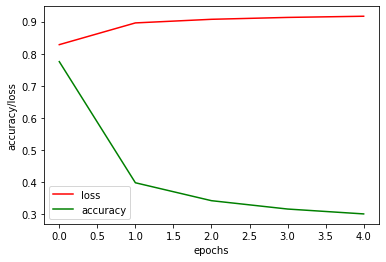

Test : loss = 0.28811509907245636, acc = 0.9210000038146973


(tensor(0.9210), 0.28811509907245636)

In [30]:
net = one_layer_Net()
train_and_plot(net, trainset, epochs = 5)
test(net, testset)

Точность больше 0.85 - хватило 5 эпох, подошли параметры: размер батча - 200, learning rate - 0.001, функция нормировки - log_Softmax, функция активации - relu, функция ошибки - nll_loss.

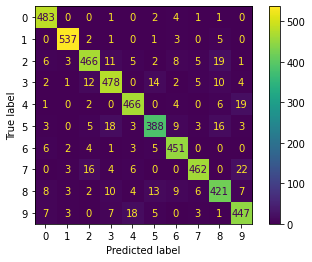

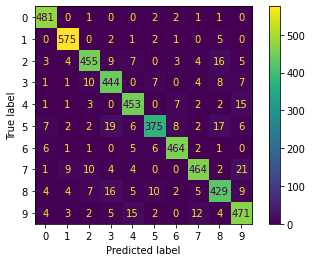

In [31]:
for x, y in testset:
  cm = confusion_matrix(y, predict(net, x))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot()
  plt.show()

Опишем четырехслойные персептрон

In [14]:
class four_layer_Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(28*28, 64)
    self.fc2 = nn.Linear(64, 64)
    self.fc3 = nn.Linear(64, 64)
    self.fc4 = nn.Linear(64, 10)

  def forward(self,x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = self.fc4(x)
    return F.log_softmax(x, dim=1)


0. loss = 0.578752. acc = 0.826717
1. loss = 0.221574. acc = 0.936167
2. loss = 0.165621. acc = 0.951650
3. loss = 0.130443. acc = 0.960983
4. loss = 0.106944. acc = 0.967900


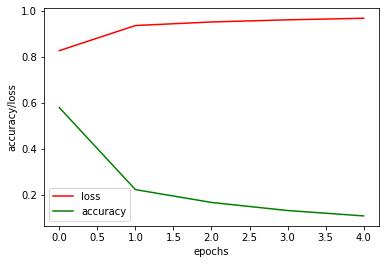

Test : loss = 0.11457040160894394, acc = 0.9664999842643738


(tensor(0.9665), 0.11457040160894394)

In [33]:
net = four_layer_Net()
train_and_plot(net, trainset, epochs = 5)
test(net, testset)

Точность больше 0.85 - хватило 5 эпох, подошли параметры: размер батча - 200, learning rate - 0.001, функция нормировки - log_Softmax, функция активации - relu, функция ошибки - nll_loss.

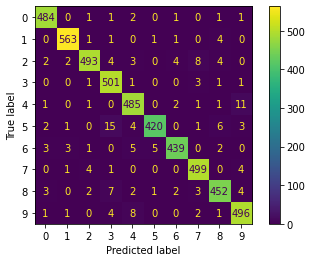

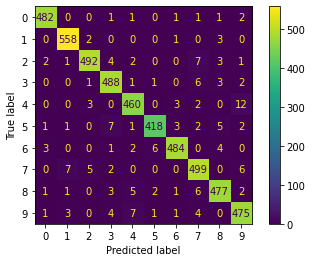

In [34]:
for x, y in testset:
  cm = confusion_matrix(y, predict(net, x))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot()
  plt.show()

Сравним различные гиепрпараметры на примере двухслойного персептрона (т.к. даже при одном слое точно получилась высокой, для теста - больше 90%)

Рассмотрим такие передаточные функции как: сигмоида, ReLu, tahn, selu.

In [35]:
class two_layer_Net_relu(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(28*28, 150)
    self.fc2 = nn.Linear(150, 10)

  def forward(self,x):
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return F.log_softmax(x, dim=1)

class two_layer_Net_tanh(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(28*28, 150)
    self.fc2 = nn.Linear(150, 10)

  def forward(self,x):
    x = F.tanh(self.fc1(x))
    x = self.fc2(x)
    return F.log_softmax(x, dim=1)

class two_layer_Net_sigmoid(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(28*28, 150)
    self.fc2 = nn.Linear(150, 10)

  def forward(self,x):
    x = F.sigmoid(self.fc1(x))
    x = self.fc2(x)
    return F.log_softmax(x, dim=1)

class two_layer_Net_selu(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(28*28, 150)
    self.fc2 = nn.Linear(150, 10)

  def forward(self,x):
    x = F.selu(self.fc1(x))
    x = self.fc2(x)
    return F.log_softmax(x, dim=1)

0. loss = 0.461749. acc = 0.880750
1. loss = 0.216766. acc = 0.938517
2. loss = 0.160046. acc = 0.954083
3. loss = 0.125746. acc = 0.964267
4. loss = 0.102960. acc = 0.970583


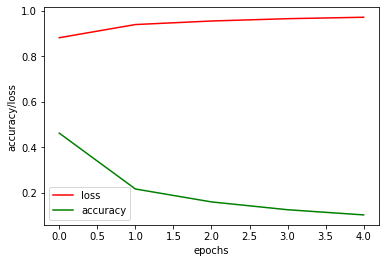

Test : loss = 0.10309882462024689, acc = 0.9692000150680542


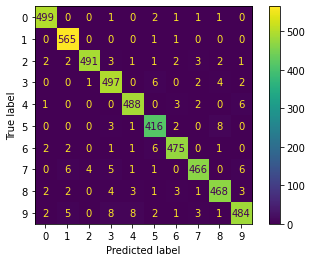

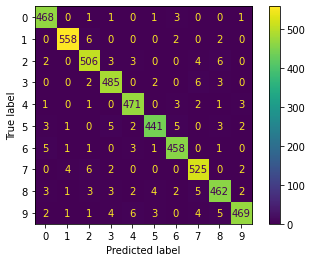

In [36]:
net = two_layer_Net_relu()
train_and_plot(net, trainset, epochs = 5)
test(net, testset)
for x, y in testset:
  cm = confusion_matrix(y, predict(net, x))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot()
  plt.show()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


0. loss = 0.451689. acc = 0.883083
1. loss = 0.220120. acc = 0.936617
2. loss = 0.165646. acc = 0.952367
3. loss = 0.132335. acc = 0.962667
4. loss = 0.108254. acc = 0.969233


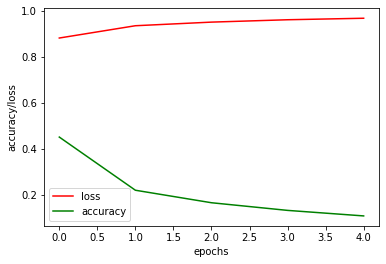

Test : loss = 0.11243542656302452, acc = 0.9661999940872192


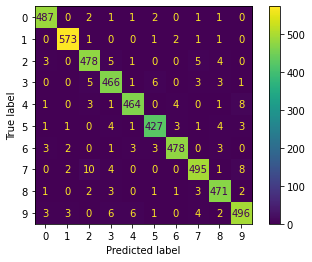

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


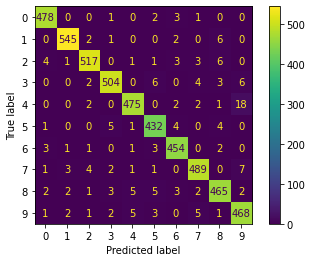

In [37]:
net = two_layer_Net_tanh()
train_and_plot(net, trainset, epochs = 5)
test(net, testset)
for x, y in testset:
  cm = confusion_matrix(y, predict(net, x))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot()
  plt.show()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0. loss = 0.775588. acc = 0.832633
1. loss = 0.302324. acc = 0.916317
2. loss = 0.241978. acc = 0.931700
3. loss = 0.204759. acc = 0.942350
4. loss = 0.177642. acc = 0.949767


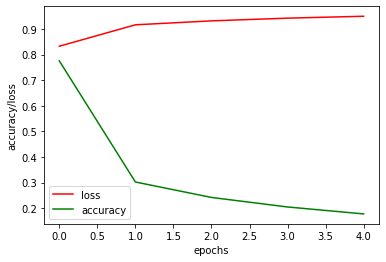

Test : loss = 0.16968882083892822, acc = 0.9513000249862671


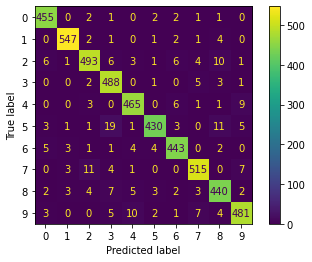

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


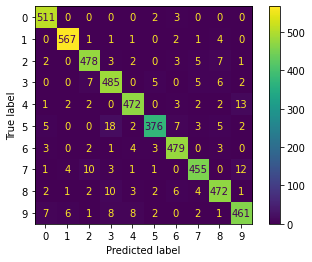

In [38]:
net = two_layer_Net_sigmoid()
train_and_plot(net, trainset, epochs = 5)
test(net, testset)
for x, y in testset:
  cm = confusion_matrix(y, predict(net, x))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot()
  plt.show()

0. loss = 0.431304. acc = 0.885200
1. loss = 0.247466. acc = 0.929317
2. loss = 0.195811. acc = 0.943867
3. loss = 0.155989. acc = 0.955483
4. loss = 0.126550. acc = 0.963567


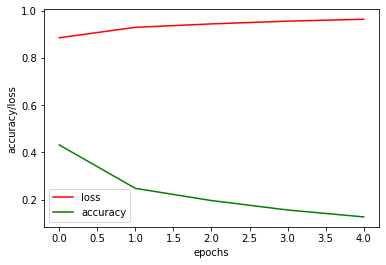

Test : loss = 0.12392403185367584, acc = 0.9639000296592712


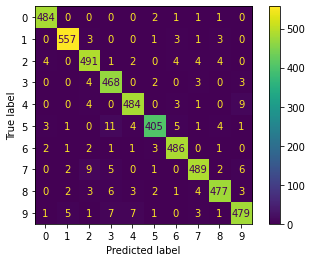

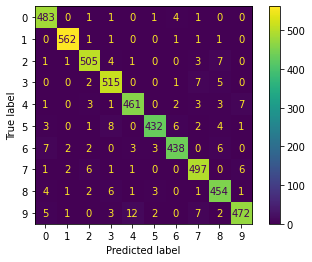

In [39]:
net = two_layer_Net_selu()
train_and_plot(net, trainset, epochs = 5)
test(net, testset)
for x, y in testset:
  cm = confusion_matrix(y, predict(net, x))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot()
  plt.show()

В качестве начальных параметров выбрана двухслойная сеть и параметры : размер батча - 200, количество эпох - 5, количество нейронов на втором слое - 150, learning rate - 0.001, функция нормировки - log_Softmax, функция ошибки - nll_loss. Результаты на тестовой выборке relu - 96.9, tanh - 96.6, sigmoid - 95.1, selu - 96.3.

Рассмотрим различное число слоев на промежуточном уровне.

In [40]:
class two_layer_Net_num(nn.Module):
  def __init__(self, num):
    super().__init__()
    self.fc1 = nn.Linear(28*28, num)
    self.fc2 = nn.Linear(num, 10)

  def forward(self,x):
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return F.log_softmax(x, dim=1)

In [41]:
import numpy as np

0. loss = 2.307246. acc = 0.108267
1. loss = 2.302291. acc = 0.110900
2. loss = 2.302496. acc = 0.111117
3. loss = 2.302442. acc = 0.110167
4. loss = 2.302415. acc = 0.111100
Test : loss = 2.30215585231781, acc = 0.11349999904632568
0. loss = 0.294142. acc = 0.910433
1. loss = 0.159548. acc = 0.953150
2. loss = 0.131563. acc = 0.961117
3. loss = 0.118922. acc = 0.964433
4. loss = 0.114928. acc = 0.965833
Test : loss = 0.1771182268857956, acc = 0.9562000036239624
0. loss = 0.258123. acc = 0.922483
1. loss = 0.139703. acc = 0.958133
2. loss = 0.119382. acc = 0.964783
3. loss = 0.103873. acc = 0.969433
4. loss = 0.099076. acc = 0.972300
Test : loss = 0.16125576943159103, acc = 0.9609000086784363
0. loss = 0.232484. acc = 0.929017
1. loss = 0.128831. acc = 0.961200
2. loss = 0.118786. acc = 0.965467
3. loss = 0.097512. acc = 0.971967
4. loss = 0.092758. acc = 0.974200
Test : loss = 0.1598595678806305, acc = 0.9648000001907349
0. loss = 0.243309. acc = 0.925917
1. loss = 0.127038. acc = 0.9

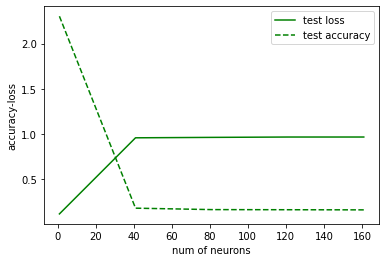

In [45]:
ox =[]
acc_test=[]
loss_test=[]

for i in np.arange(1,200,40):
    ox.append(i)
    net = two_layer_Net_num(i)
    train(net, trainset, epochs = 5)

    acc, loss = test(net, testset)
    acc_test.append(acc)
    loss_test.append(loss)

plt.ylabel('accuracy-loss')
plt.xlabel('num of neurons')
plt.plot(ox, acc_test, 'g')
plt.plot(ox, loss_test, 'g--')
plt.legend({'test accuracy','test loss'})
plt.show()

В качестве начальных параметров выбрана двухслойная сеть и параметры : размер батча - 200, количество эпох - 5, learning rate - 0.001, функция нормировки - log_Softmax, функция активации - relu, функция ошибки - nll_loss. Точность становится стобильно 96% начиная с 40 нейронов.

Рассмотрим датасет fashionMNIST.

In [19]:
train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST("", train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                   ])),
    batch_size=200, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
    ])),
    batch_size=5000, shuffle=True)

b_size = 200
b_size_test = 5000

In [20]:
for x, y in test_loader:
  print(x.shape)
  break

torch.Size([5000, 1, 28, 28])


0. loss = 0.773867. acc = 0.720950
1. loss = 0.460480. acc = 0.838333
2. loss = 0.414387. acc = 0.853233
3. loss = 0.388728. acc = 0.862517
4. loss = 0.367374. acc = 0.868300


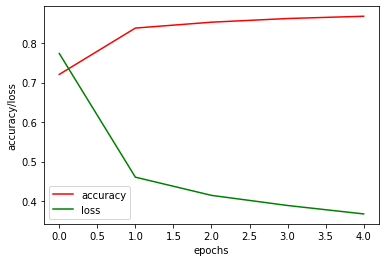

Test : loss = 0.40089699625968933, acc = 0.8585000038146973


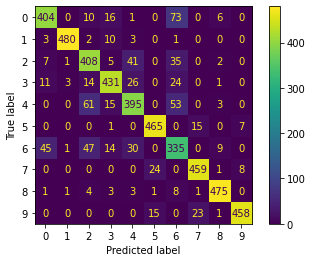

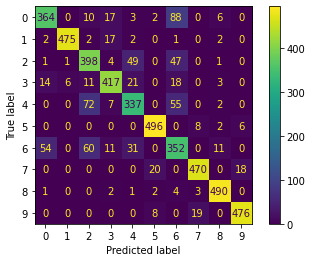

In [22]:
net = four_layer_Net()
train_and_plot(net, train_loader, epochs = 5)
test(net, test_loader)
for x, y in test_loader:
  cm = confusion_matrix(y, predict(net, x))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot()
  plt.show()

Получили точность выше 85% для четырехслойного персептрона.